# Beta Bank Customer Retention Model 

## Introducton 

Beta Bank has been experiencing customer churn, where customers are gradually leaving the bank. Retaining existing customers is more cost-effective than acquiring new ones, so the bank wants to predict which customers are at risk of leaving. In this project, we will build a machine learning model to predict customer churn based on past behavior and contract termination data. The primary metric for evaluation is the F1 score, and we aim to achieve an F1 score of at least 0.59. Additionally, we will compare the AUC-ROC metric with the F1 score to ensure the model's effectiveness.

## Import Libraries 

In [1]:
#import libraries 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.utils import resample
from sklearn.utils import shuffle


## Data Loading 
We'll begin by loading the dataset and inspecting the first 5 rows. We will also check for duplicates and missing values

In [2]:
#load data 
data =pd.read_csv('/datasets/Churn.csv')
#display the first 5 rows 
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


- We have successfully loaded the dataset. The features include demographic details, account information, and the target variable (`Exited`), which indicates whether a customer has churned.


- Initial inspection reveals categorical variables (`Geography` and `Gender`) that need encoding, and numerical variables that need scaling for optimal model performance.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


The `data` dataframe contains 10000 rows and 14 columns: 

- `RowNumber` — data string index
- `CustomerId` — unique customer identifier
- `Surname` — surname
- `CreditScore` — credit score
- `Geography` — country of residence
- `Gender` — gender
- `Age` — age
- `Tenure` — period of maturation for a customer’s fixed deposit (years)
- `Balance` — account balance
- `NumOfProducts` — number of banking products used by the customer
- `HasCrCard` — customer has a credit card
- `IsActiveMember` — customer’s activeness
- `EstimatedSalary` — estimated salary

The `Tenure` column contains 9091 non-null values indicating missing values

In [4]:
#check for duplicates
data.duplicated().sum()

0

There are no duplicates in the `data` dataframe 

In [5]:
#check for missing values
data.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

We have verified that there are 909 missing values in the `Tenure` column.
- Since 9% of the `Tenure` data is missing we will fill in those values with the median of the column 

In [6]:
# Fill missing values in 'Tenure' with the median
median_tenure = data['Tenure'].median()
data['Tenure'].fillna(median_tenure, inplace=True)

# Verify that there are no more missing values
data['Tenure'].isnull().sum()

0

Missing values have now been filled with `median_tenure`

## Data Preprocessing

This step includes encoding categorical variables, scaling numerical features, and splitting the data into training, validation, and test sets.

In [7]:
# Encoding categorical variables
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data = pd.get_dummies(data, columns=['Geography'], drop_first=True)

#split data into tranining and temporary set
df_train, df_temp = train_test_split(data, train_size=0.60, random_state=50)

#split temporary set into test set and validation set 
df_test, df_valid = train_test_split(df_temp, train_size=0.5, random_state=50)

#seperate features and target of train set, validation set, and test set
features_train= df_train.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
target_train= df_train['Exited']
features_valid=df_valid.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
target_valid=df_valid['Exited']
features_test= df_test.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
target_test= df_test['Exited']


Here the categorical variable `Gender` is encoded into a numerical format.  

The multi-class categorical variable `Geography` is converted into multiple binary columns, representing each category using One-Hot encoding.

Then, we split the source data,`data`, into a training set,`df_train`, containing 60% of the source data. Taking the remaining 40% of data, `df_temp`, and spliting that into a test set, `df_test`, and a validation set `df_valid` both containing 20% of the source data.

After creating these new data sets, features: (`CreditScore`, `Geography` , `Gender` , `Age` , `Tenure`, `Balance`, `NumOfProducts`, `HasCrCard` , `IsActiveMember` and `EstimatedSalary`) are separated from the target variable (`Excited`) in each of these sets.

In [8]:
# Scaling numerical features
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

The numeric features are now standardized using the `StandardScaler` from the `sklearn.preporcessing` module

## Initial Model Training 

Next, we train the models (Logistic Regression, Decision Tree, and Random Forest) without addressing class imbalance and evaluate their performance on the validation set.

In [9]:
# Train Logistic Regression
log_reg = LogisticRegression(random_state=50, solver="liblinear")
log_reg.fit(features_train, target_train)
target_pred_log = log_reg.predict(features_valid)

# Train Decision Tree
tree = DecisionTreeClassifier(random_state=50)
tree.fit(features_train, target_train)
target_pred_tree = tree.predict(features_valid)

# Train Random Forest
forest = RandomForestClassifier(random_state=50)
forest.fit(features_train, target_train)
target_pred_forest = forest.predict(features_valid)

# Calculate F1 scores
f1_log = f1_score(target_valid, target_pred_log)
f1_tree = f1_score(target_valid, target_pred_tree)
f1_forest = f1_score(target_valid, target_pred_forest)

# Calculate AUC-ROC
roc_auc_log = roc_auc_score(target_valid, target_pred_log)
roc_auc_tree = roc_auc_score(target_valid, target_pred_tree)
roc_auc_forest = roc_auc_score(target_valid, target_pred_forest)

# Display the F1 scores and ROC-AUC scores

(f1_log, f1_tree, f1_forest), (roc_auc_log, roc_auc_tree, roc_auc_forest)


((0.38144329896907214, 0.5199063231850117, 0.5887445887445887),
 (0.6160129460976784, 0.6975540389379249, 0.7212988667635811))

The F1 scores of the Logistic Regression, Decision Tree, and Random Forest models were 38%, 51%, and 58% respectivly. These scores do not meet our minimum requirement of 59% indicating that the models need improvement, probably in handling class imbalance, as the minority class (customers who exited) is likely underrepresented.

The AUC-ROC score of the Logistic Regression, Decision Tree, and Random Forest models were 61%, 69%, and 72% respectivly.


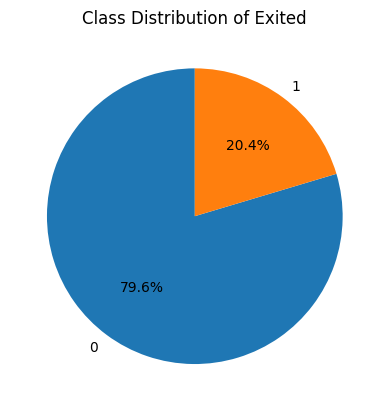

In [10]:
# Examine the distribution of the 'Exited' column
class_distribution = data['Exited'].value_counts()

# Plot a pie chart of the class distribution
class_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution of Exited')
plt.ylabel('')  # Hide the y-label
plt.show()

by observing the class distibution of our source data we can verify there in an imblance of the `Exited` class.

Exited = 0 contains 80% of the instances while Exited = 1 contains 20% of the intances

## Handling Class Imbalance 

To improve model performance, we will apply the techniques of class weight adjustments and upsampling. We will then retrain the models and select the best-performing one.

### Class Weight Adjustments 

In [11]:
# Initialize models with class weight adjustment
log_reg_weighted = LogisticRegression(random_state=50, solver="liblinear", class_weight='balanced')
tree_weighted = DecisionTreeClassifier(random_state=50, class_weight='balanced')
forest_weighted = RandomForestClassifier(random_state=50, class_weight='balanced')

# Train models with class weights
log_reg_weighted.fit(features_train, target_train)
tree_weighted.fit(features_train, target_train)
forest_weighted.fit(features_train, target_train)

# Predict on validation set
target_pred_log_weighted = log_reg_weighted.predict(features_valid)
target_pred_tree_weighted = tree_weighted.predict(features_valid)
target_pred_forest_weighted = forest_weighted.predict(features_valid)

# Calculate F1 scores
f1_log_weighted = f1_score(target_valid, target_pred_log_weighted)
f1_tree_weighted = f1_score(target_valid, target_pred_tree_weighted)
f1_forest_weighted = f1_score(target_valid, target_pred_forest_weighted)

# Calculate AUC-ROC
roc_auc_log = roc_auc_score(target_valid, target_pred_log_weighted)
roc_auc_tree = roc_auc_score(target_valid, target_pred_tree_weighted)
roc_auc_forest = roc_auc_score(target_valid, target_pred_forest_weighted)


# Display the F1 scores
(f1_log_weighted, f1_tree_weighted, f1_forest_weighted),(roc_auc_log, roc_auc_tree, roc_auc_forest)

((0.49500000000000005, 0.5166666666666666, 0.570162481536189),
 (0.7013475957786302, 0.6944337516359997, 0.7097536527891625))

The F1 scores of the Logistic Regression, Decision Tree, and Random Forest models after class weight adjustments were 49%, 51%, and 57% respectively. These scores do not meet our minimum requirement of 59% indicating that the models need improvement.

The AUC-ROC score of the Logistic Regression, Decision Tree, and Random Forest models were 70%, 69%, and 70% respectivly.


###  Upsampling 

In [12]:
# Convert target_train to a Series 
target_train = pd.Series(target_train).reset_index(drop=True)

# Ensure features_train is a DataFrame
features_train = pd.DataFrame(features_train).reset_index(drop=True)

# Write the upsampling function
def upsample(features, target, repeat):
    # Isolate the minority class
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # Upsample the minority class
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat, axis=0)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat, axis=0)
    
    # Shuffle the upsampled data
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

# Apply upsampling to the training set only
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 10)

# Initialize models without class weight adjustment
log_reg_upsampled = LogisticRegression(random_state=50, solver="liblinear")
tree_upsampled = DecisionTreeClassifier(random_state=50)
forest_upsampled = RandomForestClassifier(random_state=50)

# Train models on the upsampled training data
log_reg_upsampled.fit(features_train_upsampled, target_train_upsampled)
tree_upsampled.fit(features_train_upsampled, target_train_upsampled)
forest_upsampled.fit(features_train_upsampled, target_train_upsampled)

# Predict on the validation set
target_pred_log_upsampled = log_reg_upsampled.predict(features_valid)
target_pred_tree_upsampled = tree_upsampled.predict(features_valid)
target_pred_forest_upsampled = forest_upsampled.predict(features_valid)

# Calculate F1 scores and ROC-AUC for the validation set
f1_log_upsampled = f1_score(target_valid, target_pred_log_upsampled)
f1_tree_upsampled = f1_score(target_valid, target_pred_tree_upsampled)
f1_forest_upsampled = f1_score(target_valid, target_pred_forest_upsampled)

roc_auc_log_upsampled = roc_auc_score(target_valid, target_pred_log_upsampled)
roc_auc_tree_upsampled = roc_auc_score(target_valid, target_pred_tree_upsampled)
roc_auc_forest_upsampled = roc_auc_score(target_valid, target_pred_forest_upsampled)

# Display the F1 scores and ROC-AUC scores
(f1_log_upsampled, f1_tree_upsampled, f1_forest_upsampled), (roc_auc_log_upsampled, roc_auc_tree_upsampled, roc_auc_forest_upsampled)


((0.41170097508125675, 0.5292014302741359, 0.6030927835051546),
 (0.6223410759330292, 0.7022978719550027, 0.7403368461096042))

The F1 scores of the Logistic Regression, Decision Tree, and Random Forest models after upsampling were 41%, 52%, and 60% respectively.  
- However, we can see that the Random Forest model is performing the best in terms of F1 score with 60% indicating the best balance between precision and recall among the models.

The AUC-ROC score of the Logistic Regression, Decision Tree, and Random Forest models were 62%, 70%, and 74% respectivly.
- The Random Forest model's AUC-ROC score of 0.74.03 is the highest among the models, showing the best performance in class discrimination.

In [13]:
# Initialize upsampled models with class weight adjustment
log_reg_upsampled_balanced = LogisticRegression(random_state=50, solver="liblinear", class_weight='balanced')
tree_upsampled_balanced = DecisionTreeClassifier(random_state=50, class_weight='balanced')
forest_upsampled_balanced = RandomForestClassifier(random_state=50, class_weight='balanced')

# Train models on the upsampled training data
log_reg_upsampled_balanced.fit(features_train_upsampled, target_train_upsampled)
tree_upsampled_balanced.fit(features_train_upsampled, target_train_upsampled)
forest_upsampled_balanced.fit(features_train_upsampled, target_train_upsampled)

# Predict on the validation set
target_pred_log = log_reg_upsampled_balanced.predict(features_valid)
target_pred_tree = tree_upsampled_balanced.predict(features_valid)
target_pred_forest = forest_upsampled_balanced.predict(features_valid)

# Calculate F1 scores and ROC-AUC for the validation set
f1_log = f1_score(target_valid, target_pred_log)
f1_tree = f1_score(target_valid, target_pred_tree)
f1_forest = f1_score(target_valid, target_pred_forest)
roc_auc_log = roc_auc_score(target_valid, target_pred_log)
roc_auc_tree = roc_auc_score(target_valid, target_pred_tree)
roc_auc_forest = roc_auc_score(target_valid, target_pred_forest)

# Display the F1 scores and ROC-AUC scores
(f1_log, f1_tree, f1_forest), (roc_auc_log, roc_auc_tree, roc_auc_forest)

((0.49500000000000005, 0.5284360189573459, 0.5943877551020408),
 (0.7013475957786302, 0.7022261672395496, 0.736297228876923))

The F1 scores of the Logistic Regression, Decision Tree, and Random Forest models after upsampling and class weight balancing were 49%, 52%, and 59% respectively.

The AUC-ROC score of the Logistic Regression, Decision Tree, and Random Forest models were 70%, 70%, and 73% respectivly.

Since our minimum F1 Score is 59% the Random Forest model meets our reqiurement. However, the model `f1_forest_upsampled` performed better with an F1 score of 60%

#### Tuning Hyperparameters

Fine-tune hyperparameters to find the best setting for the model.

In [14]:
# Define the range of max_depth to test
max_depth_options = [None, 10, 20, 30, 40]
n_estimators_options = [100, 200, 300]

# Variables to store the best score and parameters
best_f1 = 0
best_max_depth = 40
best_n_estimator= 300

# Loop over all possible max_depth values
for n_estimators in n_estimators_options:
    for max_depth in max_depth_options:
        # Initialize the model with the current max_depth
        model = RandomForestClassifier(
             n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=2,  # Fixed value
            min_samples_leaf=1,   # Fixed value
            class_weight='balanced',  # To handle class imbalance
            random_state=50
        )

    # Fit the model on the upsampled training data
    model.fit(features_train_upsampled, target_train_upsampled)

    # Predict on the validation set
    target_pred_valid = model.predict(features_valid)

    # Calculate F1 score and ROC-AUC
    f1 = f1_score(target_valid, target_pred_valid)
    roc_auc = roc_auc_score(target_valid, target_pred_valid)

    # Update the best max_depth if the current model is better
    if f1 > best_f1:
        best_f1 = f1
        best_max_depth = max_depth
        best_n_estimator= n_estimators

    print(f"max_depth: {max_depth}")
    print(f"n_estimators: {n_estimators}")
    print(f"F1 Score: {f1}, ROC-AUC: {roc_auc}")
    

# Print the best max_depth
print(f'Best F1 Score: {best_f1}')
print(f'Best max_depth: {best_max_depth}')
print(f"Best_n_estimators: {n_estimators}")

# Train final model with the best max_depth
best_model = RandomForestClassifier(
    n_estimators=100,  # Fixed value
    max_depth=best_max_depth,
    min_samples_split=2,  # Fixed value
    min_samples_leaf=1,   # Fixed value
    class_weight='balanced',
    random_state=50
)

best_model.fit(features_train_upsampled, target_train_upsampled)

# Test the final model on the test set
target_pred_test = best_model.predict(features_test)
f1_test = f1_score(target_test, target_pred_test)
roc_auc_test = roc_auc_score(target_test, target_pred_test)

print(f'Final F1 Score on Test Data: {f1_test}')
print(f'Final ROC-AUC Score on Test Data: {roc_auc_test}')

max_depth: 40
n_estimators: 100
F1 Score: 0.5943877551020408, ROC-AUC: 0.736297228876923
max_depth: 40
n_estimators: 200
F1 Score: 0.6043533930857875, ROC-AUC: 0.7417747143510572
max_depth: 40
n_estimators: 300
F1 Score: 0.6128205128205128, ROC-AUC: 0.7466196887562477
Best F1 Score: 0.6128205128205128
Best max_depth: 40
Best_n_estimators: 300
Final F1 Score on Test Data: 0.6074270557029178
Final ROC-AUC Score on Test Data: 0.7489294440666011


After hypertuning the `max_depth` and `n_estimators` the final F1 and ROC-AUC scores are 60% and 74% respectively.

# Conclusion 

In this project, we successfully built a model to predict customer churn for Beta Bank using various machine learning techniques. 

By addressing class imbalance and optimizing model parameters, we achieved an F1 score above the required threshold of 0.59. The Random Forest model, with class weights adjusted and minority classes upsampled, was the best performer, making it the most suitable for deployment. 

The additional AUC-ROC score further validated the model's strength. Beta Bank can now use this model to identify at-risk customers and implement strategies to retain them, thereby reducing churn and improving profitability.